In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import time
from IPython import display

In [2]:
(train_images, train_labels), (_,_) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
train_images.shape

(60000, 28, 28)

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

In [5]:
train_images = (train_images - 127.5)/127.5

In [6]:
buffer_size = 60000
batch_size = 256

In [7]:
train_set = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

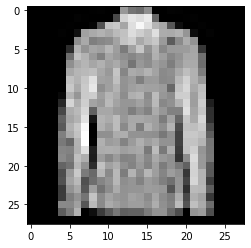

In [8]:
plt.imshow(train_images[112].reshape((28,28)), cmap= 'gray')

In [9]:
def make_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, input_shape=(100,), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape((7,7,256)))

    model.add(tf.keras.layers.Conv2DTranspose(128, (5,5),strides=(1,1), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5,5),strides=(2,2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5,5),strides=(2,2), padding='same', use_bias=False, activation= 'tanh'))

    model.summary()
    return model

In [10]:
noise = tf.random.normal([1,100])

In [11]:
generator = make_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [12]:
img_generated = generator(noise, training = False)

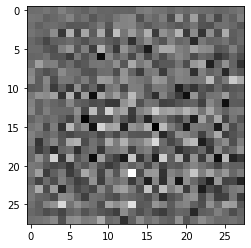

In [13]:
plt.imshow(img_generated[0,:,:,0], cmap='gray')

In [14]:
def make_discriminator():
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv2D(64, (5,5), strides = (2,2), padding = 'same', input_shape = [28,28,1]))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))

  model.add(tf.keras.layers.Conv2D(128, (5,5), strides = (2,2), padding = 'same'))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1))

  return model

In [15]:
discriminator = make_discriminator()

In [16]:
decision = discriminator(img_generated, training = False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00329038]], dtype=float32)>

In [17]:
crossentropy = tf.keras.losses.BinaryCrossentropy(from_logits= True)

In [18]:
def discriminator_loss(real_output, fake_output):
  #real_loss = crossentropy()
  real_loss = crossentropy(tf.ones_like(real_output), real_output)
  fake_loss = crossentropy(tf.zeros_like(fake_output), fake_output)

  total_loss = real_loss + fake_loss

  return total_loss


In [19]:
def generator_loss(fake_output):
  return crossentropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator
                                 )

In [ ]:
epochs = 100
noise_dim = 100
num_samples_to_generate = 16

In [ ]:
seed = tf.random.normal([num_samples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_steps(images):
  noise = tf.random.normal([batch_size,noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_im = generator(noise, training = True)

    real_output = discriminator(images, training = True)
    fake_output = discriminator(generated_im, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training = False)
  fig = plt.figure(figsize = (10,10))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0]*127.5 + 127.5, cmap ='gray')
    plt.axis('off')
  plt.savefig(f'image_at_epoch{epoch:04d}.png')
  plt.show()

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_steps(image_batch)

    display.clear_output(wait = True)
    generate_and_save_images(generator, epoch+1, seed)

    if (epochs+1) % 15 ==0:
      checkpoint.save(file_prefix=checkpoint_prefix)
    print(f'Epoch: {epoch}, Time: {(time.time() - start):.3f} s')

  display.clear_output(wait = True)
  generate_and_save_images(generator, epoch+1, seed)

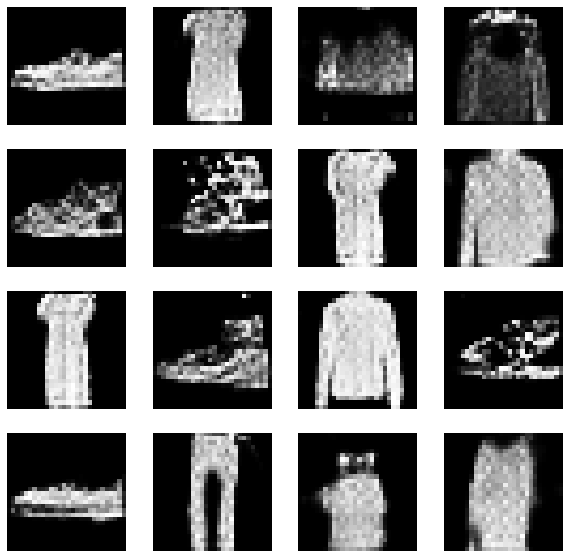

In [ ]:
train(train_set, epochs)